# fieldgen and siggen

<b>fieldgen and siggen are used together to produce simulated signals.</b>

They use a common config file to define the detector geometry, impurity profile, file names, etc. Those config files will let you describe an ICPC detector, a PPC detector, a BEGe, or even a coaxial detector.

fieldgen is a stand-alone program used to calculate the electric and weighting potentials inside a detector.

siggen is a library of functions to use those potentials, together with charge mobilities and Remo's theorem, to calculate signals.
stester (signal_tester.c) is an example code using the siggen library. It can be used to produce signals from any valid location inside the detector. Or you can use it as a template to build your own special-purpose code.

You can get the codes from github:

git clone https://github.com/radforddc/icpc_siggen.git

cd icpc_siggen; make

<b>To run this notebook, first move it into the icpc_siggen directory.</b>


### Config file example: Mirion crystal number 50372

Here is an example of a config file for a very recent crystal blank from Mirion. It specifies the geometry for a 4-kg ICPC detector.

In [10]:
import subprocess
subprocess.run("cat config_files/50372.config", shell=True).stdout

# Canberra crystal number 50372
# Seed end / Middle of crystal, 0 - 110 mm from seed
# all lengths are in mm
# format is <key_word> <value> # comment, with key_word starting at beginning of line

# ./mjd_fieldgen config_files/mirion_enr/50372.config -r config_files/mirion_enr/50372.spe -z 10

# general
verbosity_level      1   #  0 = terse, 1 = normal, 2 = chatty/verbose

# detector geometry
xtal_length        111   # z length
xtal_radius         46   # radius
top_bullet_radius    3   # bulletization radius at top of crystal
bottom_bullet_radius 3   # bulletization radius at bottom of BEGe crystal
pc_length            0   # point contact length
pc_radius           12   # point contact radius
bulletize_PC         0   # point contact hemispherical rather than cylindrical
wrap_around_radius  15   # wrap-around radius
ditch_depth          2   # depth of ditch next to wrap-around
ditch_thickness      4   # width of ditch next to wrap-around
bottom_taper_length  0   # size of 45-degree taper

## Running mjd_fieldgen

To see command format and options, run the code with no command line parameters.

In [11]:
# To see command format and options, run the code with no command line parameters
import subprocess
subprocess.run("./mjd_fieldgen", check=False, shell=True).stdout

Usage: ./mjd_fieldgen <config_file_name> [options]
   Possible options:
      -b bias_volts
      -w {0,1}  (do_not/do write the field file)
      -d {0,1}  (do_not/do write the depletion surface)
      -p {0,1}  (do_not/do write the WP file)
      -r rho_spectrum_file_name
      -z <rho_spectrum_offset_mm>


You normally run mjd_fieldgen with the config file name as the first parameter, followed by any other desired options.

Here I am running it with the config file given above:

In [12]:
import subprocess
subprocess.run("./mjd_fieldgen config_files/50372.config -r config_files/50372.spe -z 10",
                check=False, shell=True).stdout
#subprocess.run("./mjd_fieldgen config_files/50372.config -b 4650", check=False, shell=True).stdout
#subprocess.run("./mjd_fieldgen config_files/coax_50372.config -b 6000", check=False, shell=True).stdout


Reading values from config file config_files/50372.config


 ---- starting EV calculation --- 
    0 0 1 1897.5984475934 80.3216183351 ; 2190.6480000515 2190.6480000515 bubble 2190.65 1185
    1 1 0 777.0913598193 45.7470982272 ; 2191.2959492702 2191.2959492702 bubble 2191.30 1041
    2 0 1 360.3536031583 33.5974870670 ; 2191.9438984890 2191.9438984890 bubble 2191.94 903
    3 1 0 267.9529784590 26.4646903585 ; 2192.5918477077 2192.5918477077 bubble 2192.59 853
    4 0 1 209.8209471877 22.5953951214 ; 2193.2397969265 2193.2397969265 bubble 2193.24 758
    5 1 0 167.1537343367 20.0278842717 ; 2193.8877461452 2193.8877461452 bubble 2193.89 731
    6 0 1 116.0950513763 17.8956763194 ; 2194.5356953640 2194.5356953640 bubble 2194.54 698
    7 1 0 93.7871435555 15.5815042160 ; 2195.1836445827 2195.1836445827 bubble 2195.18 625
    8 0 1 80.0168350294 13.5826991471 ; 2195.8315938015 2195.8315938015 bubble 2195.83 590
    9 1 0 63.9422268158 11.9013682855 ; 2196.4795430202 2196.4795430202 bub

### What is that "-r config_files/mirion_enr/50372.spe -z 10"? Is it needed?

<b>For simple detectors, and ones with a nice linear impurity profile, these options are not needed.</b> The impurity profile can simply be parameterized and put into the config file.

However, when optimizing the use of large enriched crystals like this one for making LEGEND detectors, we want to be as accurate as possible in our simulations. For this very large detector, these options allow me to use the 50372.spe file as the profile of the net impurity along the z-axis of the detector, and give the most accurate information that I have to the fieldgen calculation. 

50372.spe is a fit to the impurity profile provided by the manufacturer (Mirion). Each bin corresponds to 1 mm, and the impurity units are (1e10 / cm3).

The input impurity profile is plotted in the next cell below.

The "-z 10" option tells the code that the detector is not using the first 10 mm of the crystal; that material has too high an impurity value.

To see the effect of using a detailed impurity like this, try re-running fieldgen without those options: "./mjd_fieldgen config_files/mirion_enr/50372.config". You will see that the depletion voltage changes.

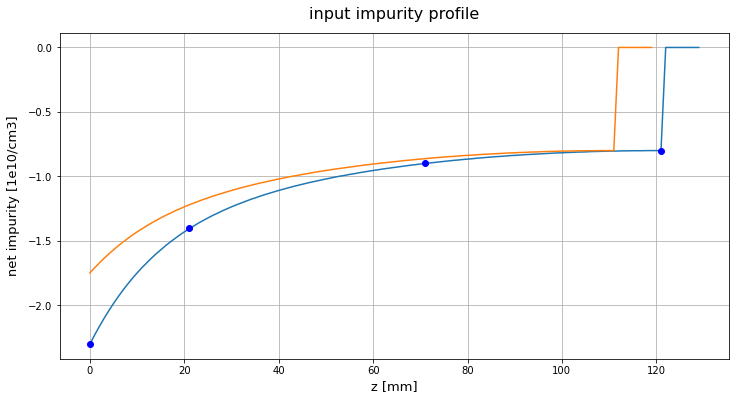

In [13]:
import sys
import numpy as np
import struct
import matplotlib.pyplot as plt
# plot the fitted impurity profile
f = open("config_files/50372.spe", 'rb')
head = f.read(36)
yraw = f.read(130*4)
y = np.array(struct.unpack('f'*130, yraw))
plt.rcParams["figure.figsize"] = 12, 6
plt.plot(y)
# plot it with the10-mm offset
plt.plot(y[10:])
# plot the data points provided by Mirion
x = [0,    21,   71,   121]
y = [-2.3, -1.4, -0.9, -0.8]
plt.plot(x, y, "bo")
plt.xlabel("z [mm]", size=13)
plt.ylabel("net impurity [1e10/cm3]", labelpad=8,  size=13)
plt.title("input impurity profile\n", fontsize=16, linespacing=0.4)
plt.grid(True)
plt.show()
f.close()

## Plotting the electric field or weighting potential

You can use fields/plot_log.py from the terminal to make plots like this from the shell. Here I have excerpted parts of that code to plot the field calculated above.

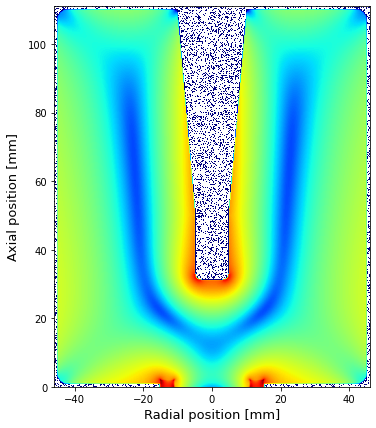

In [21]:
import matplotlib.colors as colors

data = np.loadtxt("fields/ev_50372.dat")
#data = np.loadtxt("fields/ev_c50372.dat")
# figure out the size of grid the X-Y points
x = set(data[:,0])  # sets only have one copy of anything, so if there are repeats, they are removed
y = set(data[:,1])
z = data[:,3]       # column 3 = field, 2 = potential
# reshape the zvals array into the appropriate shape, and find the boundaries
zvals = z.reshape(len(x), len(y))
zvals[zvals<0] = 0
# imshow plots columns and rows opposite to how you'd expect; so transpose them
zvals = zvals.T
# stack so we can plot the data from one half of the detector (positive r-values only)
zvals_neg = np.fliplr(zvals)
zvals_full = np.hstack((zvals_neg,zvals))
bounds = (-1*max(x), max(x), min(y), max(y))

fig = plt.figure(figsize=(10,7))
ip = plt.imshow(zvals_full, norm=colors.LogNorm(),
                extent=bounds,   # set the boundaries of the edges of the 'image' data
                origin="lower",  # tell matplotlib where [0,0] is in the bottom
                cmap='jet')      # use the 'jet color map scheme
plt.xlabel("Radial position [mm]", size=13)
plt.ylabel("Axial position [mm]", labelpad=8,  size=13)
plt.show()

### How big is that detector?

Use the "mass" program to calculate the detector mass, for either natural or enriched material.

In [15]:
subprocess.run("./mass config_files/50372.config", check=False, shell=True).stdout


Reading values from config file config_files/50372.config


      Crystal: Radius x Length: 46.0 x 111.0 mm
 Bottom taper: 0.0 mm
    Core hole: Radius x length: 4.0 x 79.0 mm, taper 5.2 x 60.0 mm ( 5 degrees), bullet radius 1.0 mm
Outside taper: 0.0 mm x 0.0 mm (5.00 degrees)
      Contact: Radius x length: 12.0 x 0.0 mm
  Wrap-around: Radius x ditch x gap:  15.0 x 2.0 x 4.0 mm

         cylinder:  737885 mm3  =  3928 g
     tapered hole:    8705 mm3  =    46 g
    straight hole:     955 mm3  =     5 g
top bullet radius:     559 mm3  =     3 g
  bottom bullet r:     559 mm3  =     3 g
            ditch:    1414 mm3  =     8 g

  final volume:  725693 mm3  =  725.7 cm3
  final   mass:  3863 g   [4023 g for enriched 76Ge]

 detector  len  diam  enr_mass Vop  well_diamxlen taper ditchOD
    50372 111.0  92.0   4023  4380   8.0x79.0   60.0 30.0


## Running siggen (stester)

The siggen functiona can be compiled with your own glue code to do whatever tailored task you need.
But if you just want to generate some signals then you'll probably find that the example code stester will do what you want.

stester is an interactive command-driven program. You could easily run it inside a terminal, for example with the command: 

./stester config_files/mirion_enr/50372.config

To get a list of the stester commands, type the command "help".
To exit the program, type the command "quit".

To show examples in this Jupyter Notebook, I'm using a work-around to pre-write my commands to stester into a file, and then redirecting the stester input from that file.


In [16]:
# To get a list of the stester commands, type "help"
f = open("my_stester_commands.txt", "w")
f.write("help\n")
f.write("quit\n")
f.close()
subprocess.run("./stester config_files/50372.config < my_stester_commands.txt", 
               check=False, shell=True).stdout


Reading values from config file config_files/50372.config
Will use 8000 time steps in calculations, each 1.00 ns long;
the output signals will have 800 time steps, each 10.00 ns long
Reading field data...
rmin: 0.00 rmax: 46.00, rstep: 0.20
zmin: 0.00 zmax: 111.00, zstep: 0.20
Detector temperature is set to 90.0 K
Drift velocity table has 20 rows of data
Adjusting mobilities for temperature, from 77.0 to 90.0
Reading electric field data from file: fields/ev_50372.dat
Done reading 128710 lines of electric field data
Reading weighting potential from file: fields/wp_50372.dat
Done reading 128710 lines of WP data
Setup of signal calculation done
available commands:
cyl ; set input system to cylindrical coords
cart ; set input system to cartesian coords
sig x y z file.spe or sig r p z file.spe ; save signal
psig x y z or psig r p z ; print signal
dp fn.dat ; extract charge drift paths to fn.dat
st %f ; set temperture in K
tau %f ; set preamp integration time in ns
ccs %f ; set charge cloud

### Here is an example of using stester to produce a couple of signals from different locations in the detector.

To generate a signal as a radware .spe file. use the "sig" command:

sig x y z output_file.spe or sig r phi z output_file.spe ; coordinates are in mm or radians

In [17]:
f = open("my_stester_commands.txt", "w")
f.write("sig 30 0 95 test1.spe\n")
f.write("sig 20 0 5 test2.spe\n")
f.write("quit\n")
f.close()
subprocess.run("./stester config_files/50372.config < my_stester_commands.txt", check=False, shell=True).stdout
#subprocess.run("./stester config_files/coax_50372.config < my_stester_commands.txt", check=False, shell=True).stdout


Reading values from config file config_files/50372.config
Will use 8000 time steps in calculations, each 1.00 ns long;
the output signals will have 800 time steps, each 10.00 ns long
Reading field data...
rmin: 0.00 rmax: 46.00, rstep: 0.20
zmin: 0.00 zmax: 111.00, zstep: 0.20
Detector temperature is set to 90.0 K
Drift velocity table has 20 rows of data
Adjusting mobilities for temperature, from 77.0 to 90.0
Reading electric field data from file: fields/ev_50372.dat
Done reading 128710 lines of electric field data
Reading weighting potential from file: fields/wp_50372.dat
Done reading 128710 lines of WP data
Setup of signal calculation done
t_90, t_10-90, A/E = 2195  396 0.053549
800 channels of data saved in spectrum test1.spe
t_90, t_10-90, A/E =  563  435 0.053428
800 channels of data saved in spectrum test2.spe


### Here are those two output signals

Blue:   test1.spe ;  (x, y, z)= (30, 0, 95) mm

Orange: test2.spe ;  (x, y, z)= (20, 0, 5) mm

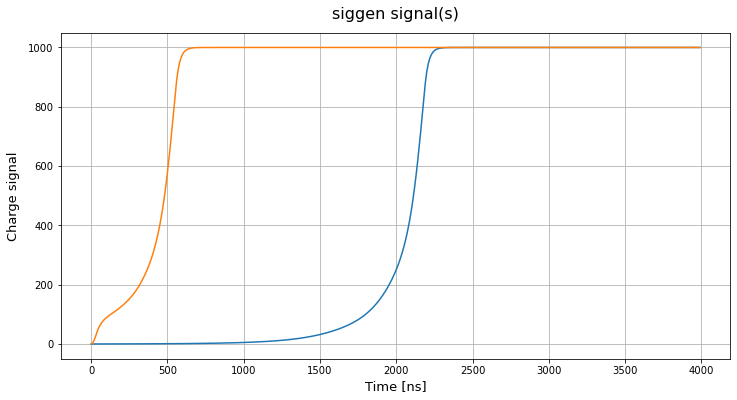

In [18]:
import sys
import numpy as np
import struct
import matplotlib.pyplot as plt
x = np.arange(0, 4000, 10)
f = open("test1.spe", 'rb')
head = f.read(36)
yraw = f.read(400*4)
y = np.array(struct.unpack('f'*400, yraw))
plt.plot(x,y)
f.close()
f = open("test2.spe", 'rb')
head = f.read(36)
yraw = f.read(400*4)
y = np.array(struct.unpack('f'*400, yraw))
plt.plot(x,y)
plt.xlabel("Time [ns]", size=13)
plt.ylabel("Charge signal", labelpad=8,  size=13)
plt.title("siggen signal(s)\n", fontsize=16, linespacing=0.4)
plt.grid(True)
plt.rcParams["figure.figsize"] = 12, 6
plt.show()
f.close()

Now you could try changing the coordinates in the stester "sig" commands above (In [8]), and see how the signals change.

Try changing the config file in the call to fieldgen (In [3]) from 50372.config to coax_50372.config. That will produce a different field file (ev_c50372.dat instead of ev_50372.dat). In order to see it you will need to change the filename in In [5] from ev_50372.dat to ev_c50372.dat.

Then you can rerun stester (In [8]) also with that coax_50372.config file. The signals will look very different for this coaxial detector!

Compare 50372.config and coax_50372.config to see how they differ for the two geometries.
